In [1]:
import tensorflow as tf
import imageio

print(tf.__version__)
print(imageio.__version__)

2.18.0
2.37.0


In [7]:
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, ReLU
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
base_dir = "/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10"
generated_samples_dir = f"{base_dir}/generated_samples"
training_checkpoints_dir = f"{base_dir}/training_checkpoints"
training_history_dir = f"{base_dir}/training_history"


In [9]:
# CIFAR-10 데이터셋 로드
(train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# 데이터 정규화 (-1 ~ 1)
train_x = (train_x.astype("float32") - 127.5) / 127.5
train_x = np.reshape(train_x, (-1, 32, 32, 3))

# 미니배치 구성
BATCH_SIZE = 256
BUFFER_SIZE = 60000

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

print("✅ 데이터셋 로드 및 전처리 완료!")


✅ 데이터셋 로드 및 전처리 완료!


In [10]:
def build_generator():
    model = tf.keras.Sequential([
        Dense(8*8*256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        ReLU(),
        Reshape((8, 8, 256)),

        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        BatchNormalization(),
        ReLU(),

        # strides=(1, 1) → (2, 2)로 변경하면 이미지 크기가 너무 커짐
        Conv2DTranspose(3, (5, 5), strides=(1, 1), padding="same", activation="tanh"),
    ])
    return model

generator = build_generator()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,507 (10.43 MB)

 Trainable params: 2,700,355 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [11]:
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(32, 32, 3)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dense(1, activation="sigmoid"),
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,034,881 (3.95 MB)

 Trainable params: 1,034,113 (3.94 MB)

 Non-trainable params: 768 (3.00 KB)

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

print("✅ 손실 함수 및 옵티마이저 설정 완료!")


✅ 손실 함수 및 옵티마이저 설정 완료!


In [13]:
import time
from tensorflow.keras.preprocessing.image import array_to_img

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        print(f"Epoch {epoch+1}/{epochs} 완료, 시간: {time.time()-start:.2f}초")

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')

    plt.savefig(f"{generated_samples_dir}/image_at_epoch_{epoch}.png")
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/50 완료, 시간: 41.40초
Epoch 2/50 완료, 시간: 25.87초
Epoch 3/50 완료, 시간: 27.05초
Epoch 4/50 완료, 시간: 27.33초
Epoch 5/50 완료, 시간: 26.67초
Epoch 6/50 완료, 시간: 26.76초
Epoch 7/50 완료, 시간: 26.94초
Epoch 8/50 완료, 시간: 26.83초
Epoch 9/50 완료, 시간: 26.80초
Epoch 10/50 완료, 시간: 26.88초


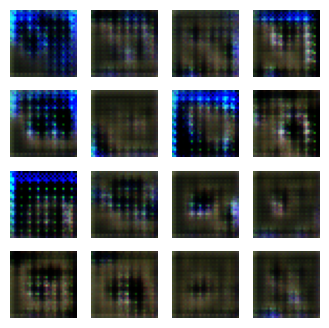

Epoch 11/50 완료, 시간: 26.86초
Epoch 12/50 완료, 시간: 26.95초
Epoch 13/50 완료, 시간: 26.92초
Epoch 14/50 완료, 시간: 26.89초
Epoch 15/50 완료, 시간: 26.84초
Epoch 16/50 완료, 시간: 26.82초
Epoch 17/50 완료, 시간: 26.84초
Epoch 18/50 완료, 시간: 26.83초
Epoch 19/50 완료, 시간: 26.90초
Epoch 20/50 완료, 시간: 26.96초


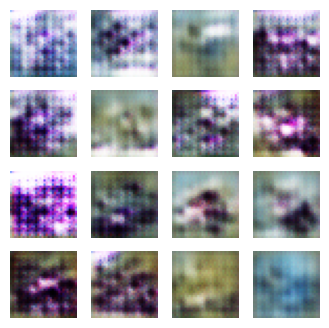

Epoch 21/50 완료, 시간: 26.85초
Epoch 22/50 완료, 시간: 26.88초
Epoch 23/50 완료, 시간: 26.87초
Epoch 24/50 완료, 시간: 26.85초
Epoch 25/50 완료, 시간: 26.83초
Epoch 26/50 완료, 시간: 26.85초
Epoch 27/50 완료, 시간: 26.90초
Epoch 28/50 완료, 시간: 26.91초
Epoch 29/50 완료, 시간: 26.91초
Epoch 30/50 완료, 시간: 26.94초


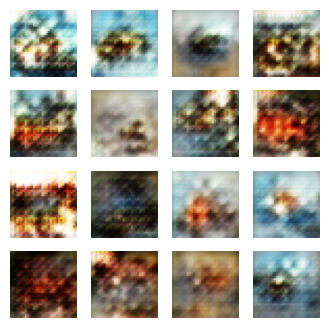

Epoch 31/50 완료, 시간: 26.90초
Epoch 32/50 완료, 시간: 26.98초
Epoch 33/50 완료, 시간: 27.00초
Epoch 34/50 완료, 시간: 26.95초
Epoch 35/50 완료, 시간: 26.92초
Epoch 36/50 완료, 시간: 26.90초
Epoch 37/50 완료, 시간: 26.86초
Epoch 38/50 완료, 시간: 26.85초
Epoch 39/50 완료, 시간: 26.87초
Epoch 40/50 완료, 시간: 26.90초


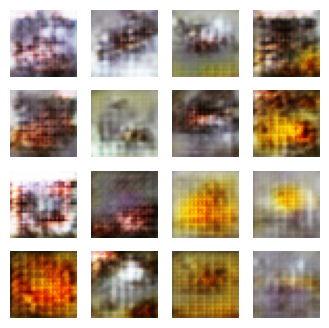

Epoch 41/50 완료, 시간: 26.88초
Epoch 42/50 완료, 시간: 26.94초
Epoch 43/50 완료, 시간: 26.94초
Epoch 44/50 완료, 시간: 26.96초
Epoch 45/50 완료, 시간: 26.96초
Epoch 46/50 완료, 시간: 26.95초
Epoch 47/50 완료, 시간: 26.95초
Epoch 48/50 완료, 시간: 26.95초
Epoch 49/50 완료, 시간: 26.97초
Epoch 50/50 완료, 시간: 26.95초


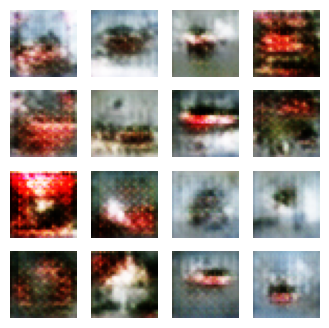

In [14]:
train(train_dataset, EPOCHS)
